---
# Empirical application
---
## Probabilistic Inference - Conformal Inference Beyond Exchangeability

* Alessandro Ciancetta
* Ramón Talvi,
* Alessandro Tenderini
* Akash Yadav
---

The code is adapted and extended from Barber et al. (2023) code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(1)

In [2]:
data = pd.read_csv("/Users/utente/desktop/BARCELLONA/TERM 2/probabilistic inference in ML/project/code/nonexchangeable_conformal/ETTm2.csv")
col_names = data.columns
df = data.iloc[-2100:]   # Select Last 2000 Row

In [3]:

data = df.to_numpy()

covariate_col = ['HUFL', 'HULL', 'MUFL', 'MULL','LUFL','LULL']
response_col = 'OT'

keep_rows = np.where((data[:,2]>data[17,2])&(data[:,2]<data[24,2]))[0]

X = data[:,np.where([t in covariate_col for t in col_names])[0]]
Y = data[:,np.where(col_names==response_col)[0]].flatten()
X = X.astype('float64')
Y = Y.astype('float64')

N = X.shape[0]; p = X.shape[1]; alpha = 0.1
train_lag = 100 # start predicting after train_lag many observations

# weights and tags (parameters for new methods)
rho = 0.96; rho_LS = 0.96

In [4]:
N

2100

In [5]:
# conformal prediction with least squares
def CP_LS(X,Y,x,alpha,weights=[],tags=[]):
    # weights are used for computing quantiles for the prediction interval
    # tags are used as weights in weighted least squares regression
    n = len(Y)
    
    if(len(tags)==0):
        tags = np.ones(n+1)
    
    if(len(weights)==0):
        weights = np.ones(n+1)
    if(len(weights)==n):
        weights = np.r_[weights,1]
    weights = weights / np.sum(weights)
    
    # randomly permute one weight for the regression
    random_ind = int(np.where(np.random.multinomial(1,weights,1))[1])
    tags[np.c_[random_ind,n]] = tags[np.c_[n,random_ind]]

    XtX = (X.T*tags[:-1]).dot(X) + np.outer(x,x)*tags[-1]
    a = Y - X.dot(np.linalg.solve(XtX,(X.T*tags[:-1]).dot(Y)))
    b = -X.dot(np.linalg.solve(XtX,x))*tags[-1]
    a1 = -x.T.dot(np.linalg.solve(XtX,(X.T*tags[:-1]).dot(Y)))
    b1 = 1 - x.T.dot(np.linalg.solve(XtX,x))*tags[-1]
    # if we run weighted least squares on (X[1,],Y[1]),...(X[n,],Y[n]),(x,y)
    # then a + b*y = residuals of data points 1,..,n
    # and a1 + b1*y = residual of data point n+1
    
    y_knots = np.sort(np.unique(np.r_[((a-a1)/(b1-b))[b1-b!=0],((-a-a1)/(b1+b))[b1+b!=0]]))
    y_inds_keep = np.where( ((np.abs(np.outer(a1+b1*y_knots,np.ones(n))) > \
       np.abs(np.outer(np.ones(len(y_knots)),a)+np.outer(y_knots,b))) *\
                             weights[:-1] ).sum(1) <= 1-alpha )[0] 
    y_PI = np.array([y_knots[y_inds_keep.min()],y_knots[y_inds_keep.max()]])
    if(weights[:-1].sum() <= 1-alpha):
        y_PI = np.array([-np.inf,np.inf])
    return y_PI


In [6]:
# conformal prediction with least squares
def CP_LS_jacknife(X,Y,x,alpha,weights=[],tags=[]):

    n = len(Y)
    if(len(tags)==0):
        tags = np.ones(n+1)

    if(len(weights)==0):
        weights = np.ones(n+1)
    if(len(weights)==n):
        weights = np.r_[weights,1]

    ## Normalized weights
    weights = weights / np.sum(weights)

    random_ind = int(np.where(np.random.multinomial(1,weights,1))[1])
    tags[np.c_[random_ind,n]] = tags[np.c_[n,random_ind]]

    XtX = (X.T*tags[:-1]).dot(X)
    XtY = (X.T*tags[:-1]).dot(Y)
    R_LOO = np.zeros(n)
    Yhat_LOO = np.zeros(n)
    for i in np.arange(n):
        # run weighted least squares on (X[j,],Y[j]) for j in {1,..,n}\{i}
        betahat = np.linalg.solve(XtX - np.outer(X[i],X[i])*tags[i],XtY - X[i]*Y[i]*tags[i])
        # compute the leave-one-out residual
        R_LOO[i] = np.abs(Y[i] - X[i].dot(betahat))
        # compute the leave-one-out prediction
        Yhat_LOO[i] = x.dot(betahat)
        
    if(np.sum(weights[:-1]) >= 1-alpha):
        ord_left = np.argsort(-(Yhat_LOO-R_LOO))
        ind_left = np.min(np.where(np.cumsum(weights[:-1][ord_left])>=1-alpha))
        PI_left = np.sort(Yhat_LOO-R_LOO)[n+1-ind_left]
        ord_right = np.argsort(Yhat_LOO+R_LOO)
        ind_right = np.min(np.where(np.cumsum(weights[:-1][ord_right])>=1-alpha))
        PI_right = np.sort(Yhat_LOO+R_LOO)[ind_right]
    else:
        jack_thresh = np.inf
        
    y_PI = np.array([PI_left,PI_right])
    return(y_PI)

In [7]:
# run all methods
PI_CP_LS = np.zeros((N,2))
PI_CP_LS[:train_lag,0]=-np.inf;PI_CP_LS[:train_lag,1]=np.inf
PI_CP_LS_perm = np.copy(PI_CP_LS)
PI_nexCP_LS = np.copy(PI_CP_LS)
PI_nexCP_LS_perm = np.copy(PI_CP_LS)
PI_nexCP_WLS = np.copy(PI_CP_LS)
PI_nexCP_WLS_perm = np.copy(PI_CP_LS)

PI_CP_Jack_LS = np.copy(PI_CP_LS)
PI_nexCP_Jack_LS = np.copy(PI_CP_LS)
PI_nexCP_Jack_WLS = np.copy(PI_CP_LS)

for n in np.arange(train_lag,N):
    weights=rho**(np.arange(n,0,-1))
    tags=rho_LS**(np.arange(n,-1,-1))
    PI_CP_LS[n,:] = CP_LS(X[:n,:],Y[:n],X[n,:],alpha)

    PI_CP_Jack_LS[n,:] = CP_LS_jacknife(X[:n,:],Y[:n],X[n,:],alpha)

    PI_nexCP_LS[n,:] = CP_LS(X[:n,:],Y[:n],X[n,:],alpha,weights=weights)

    PI_nexCP_Jack_LS[n,:] = CP_LS_jacknife(X[:n,:],Y[:n],X[n,:],alpha,weights=weights)

    PI_nexCP_WLS[n,:] = CP_LS(X[:n,:],Y[:n],X[n,:],alpha,\
                            weights=weights,tags=tags)
    
    PI_nexCP_Jack_WLS[n,:] = CP_LS_jacknife(X[:n,:],Y[:n],X[n,:],alpha,\
                            weights=weights,tags=tags)


In [8]:
# compute coverage and PI width for all settings

cov_CP_LS = (PI_CP_LS[train_lag:,0]<=Y[train_lag:])*\
    (PI_CP_LS[train_lag:,1]>=Y[train_lag:])
PI_width_CP_LS = PI_CP_LS[train_lag:,1]-PI_CP_LS[train_lag:,0]



cov_nexCP_LS = (PI_nexCP_LS[train_lag:,0]<=Y[train_lag:])*\
    (PI_nexCP_LS[train_lag:,1]>=Y[train_lag:])
PI_width_nexCP_LS = PI_nexCP_LS[train_lag:,1]-PI_nexCP_LS[train_lag:,0]


cov_nexCP_WLS = (PI_nexCP_WLS[train_lag:,0]<=Y[train_lag:])*\
    (PI_nexCP_WLS[train_lag:,1]>=Y[train_lag:])
PI_width_nexCP_WLS = PI_nexCP_WLS[train_lag:,1]-PI_nexCP_WLS[train_lag:,0]


cov_CP_Jack_LS = (PI_CP_Jack_LS[train_lag:,0]<=Y[train_lag:])*\
    (PI_CP_Jack_LS[train_lag:,1]>=Y[train_lag:])
PI_width_Jack_LS = PI_CP_Jack_LS[train_lag:,1]-PI_CP_Jack_LS[train_lag:,0]

cov_nexCP_Jack_LS = (PI_nexCP_Jack_LS[train_lag:,0]<=Y[train_lag:])*\
    (PI_nexCP_Jack_LS[train_lag:,1]>=Y[train_lag:])
PI_width_nexCP_Jack_LS = PI_nexCP_Jack_LS[train_lag:,1]-PI_nexCP_Jack_LS[train_lag:,0]

cov_nexCP_Jack_WLS = (PI_nexCP_Jack_WLS[train_lag:,0]<=Y[train_lag:])*\
    (PI_nexCP_Jack_WLS[train_lag:,1]>=Y[train_lag:])
PI_width_nexCP_Jack_WLS = PI_nexCP_Jack_WLS[train_lag:,1]-PI_nexCP_Jack_WLS[train_lag:,0]


In [9]:
pd.DataFrame({"Model":['CP+LS','nexCP+LS','nexCP+WLS','CP+LS+jackknife','nexCP+LS+jackknife','nexCP+WLS+jackknife'],"mean coverage":[np.mean(cov_CP_LS),np.mean(cov_nexCP_LS),np.mean(cov_nexCP_WLS),np.mean(cov_CP_Jack_LS),np.mean(cov_nexCP_Jack_LS),np.mean(cov_nexCP_Jack_WLS)]})

,Model,mean coverage
0,CP+LS,0.8500
1,nexCP+LS,0.8940
2,nexCP+WLS,0.9210
3,CP+LS+jackknife,0.8515
4,nexCP+LS+jackknife,0.8915
5,nexCP+WLS+jackknife,0.9035


In [10]:
window = 200 # will display a rolling average

def rolling_avg(x,window):
    return np.convolve(x,np.ones(window)/window)[(window-1):-window]
    

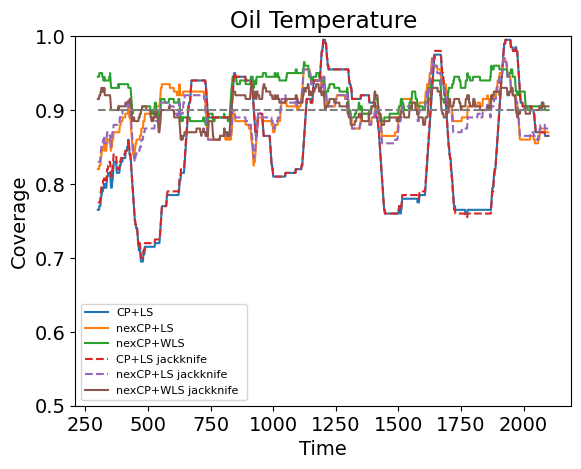

In [11]:
sm_cov_CP_LS = rolling_avg(cov_CP_LS,window)
sm_cov_nexCP_LS = rolling_avg(cov_nexCP_LS,window)
sm_cov_nexCP_WLS = rolling_avg(cov_nexCP_WLS,window)

sm_cov_CP_Jack_LS = rolling_avg(cov_CP_Jack_LS,window)
sm_cov_nexCP_Jack_LS = rolling_avg(cov_nexCP_Jack_LS,window)
sm_cov_nexCP_Jack_WLS = rolling_avg(cov_nexCP_Jack_WLS,window)

plt.rcParams.update({'font.size': 14})


plt.plot(np.arange(train_lag+window,N),sm_cov_CP_LS)
plt.plot(np.arange(train_lag+window,N),sm_cov_nexCP_LS)
plt.plot(np.arange(train_lag+window,N),sm_cov_nexCP_WLS)
plt.plot(np.arange(train_lag+window,N),sm_cov_CP_Jack_LS,linestyle='dashed')
plt.plot(np.arange(train_lag+window,N),sm_cov_nexCP_Jack_LS,linestyle='dashed')
plt.plot(np.arange(train_lag+window,N),sm_cov_nexCP_Jack_WLS)
plt.hlines(1-alpha,xmin=train_lag+window,xmax=N,linestyles='--',colors='gray')
plt.legend(['CP+LS','nexCP+LS','nexCP+WLS','CP+LS jackknife ','nexCP+LS jackknife ','nexCP+WLS jackknife '],fontsize = 8)
plt.ylabel('Coverage')
plt.xlabel('Time')
plt.title('Oil Temperature')
plt.ylim([0.5,1])
plt.savefig('results/ETTm2.png',dpi=400,bbox_inches='tight')
plt.show()

#plt.plot(Y[250:]) 
#plt.show()

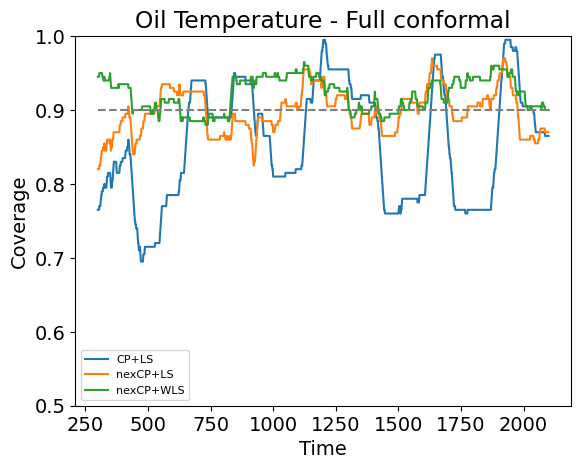

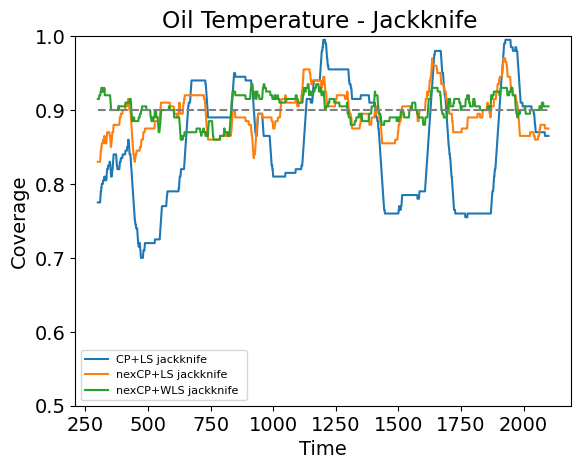

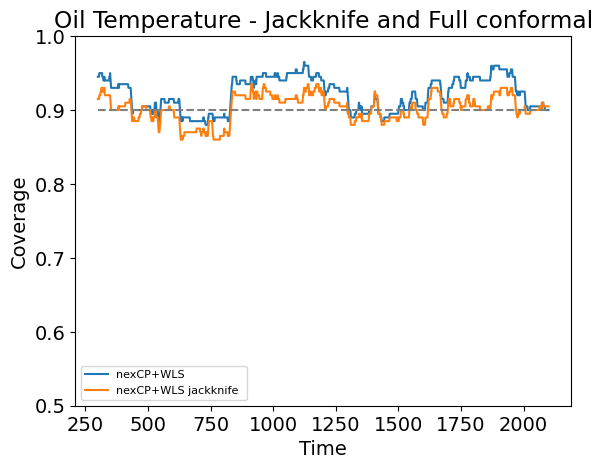

In [14]:
plt.rcParams.update({'font.size': 14})


plt.plot(np.arange(train_lag+window,N),sm_cov_CP_LS)
plt.plot(np.arange(train_lag+window,N),sm_cov_nexCP_LS)
plt.plot(np.arange(train_lag+window,N),sm_cov_nexCP_WLS)

plt.hlines(1-alpha,xmin=train_lag+window,xmax=N,linestyles='--',colors='gray')
plt.legend(['CP+LS','nexCP+LS','nexCP+WLS'],fontsize = 8)
plt.ylabel('Coverage')
plt.xlabel('Time')
plt.title('Oil Temperature - Full conformal')
plt.ylim([0.5,1])
plt.savefig('results/full.png',dpi=400,bbox_inches='tight')
plt.show()




plt.plot(np.arange(train_lag+window,N),sm_cov_CP_Jack_LS)
plt.plot(np.arange(train_lag+window,N),sm_cov_nexCP_Jack_LS)
plt.plot(np.arange(train_lag+window,N),sm_cov_nexCP_Jack_WLS)

plt.hlines(1-alpha,xmin=train_lag+window,xmax=N,linestyles='--',colors='gray')
plt.legend(['CP+LS jackknife ','nexCP+LS jackknife ','nexCP+WLS jackknife '],fontsize = 8)
plt.ylabel('Coverage')
plt.xlabel('Time')
plt.title('Oil Temperature - Jackknife ')
plt.ylim([0.5,1])
plt.savefig('results/jackknife.png',dpi=400,bbox_inches='tight')
plt.show()


plt.plot(np.arange(train_lag+window,N),sm_cov_nexCP_WLS)
plt.plot(np.arange(train_lag+window,N),sm_cov_nexCP_Jack_WLS)

plt.hlines(1-alpha,xmin=train_lag+window,xmax=N,linestyles='--',colors='gray')
plt.legend(['nexCP+WLS','nexCP+WLS jackknife '],fontsize = 8)
plt.ylabel('Coverage')
plt.xlabel('Time')
plt.title('Oil Temperature - Jackknife and Full conformal')
plt.ylim([0.5,1])
plt.savefig('results/fullJackknife.png',dpi=400,bbox_inches='tight')
plt.show()
